## Fake Data and Modelling Utility

In [12]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt 
import arviz as az


np.random.seed(100)
def softmax(x): 
    return np.exp(x)/sum(np.exp(x))

def create_probs(P=10):
    # Create a random characteristic matrix and weights matrix X and beta
    X = np.random.normal(0, 1, size=(P, 5))
    beta = np.random.normal(0, 1, size=5)
    # Draw some random demand shocks for each product
    xi = np.random.normal(0, 1, size=P)
    # Generate the fixed utilities
    mu = np.dot(X, beta) + xi
    # illustrate the probabilities
    probs = softmax(mu)
    return probs, mu

probs, mu = create_probs(P=11)

pd.DataFrame({'probs': np.round(probs*100, 2), 
              'cumulative_prod': np.cumsum(probs)})

,probs,cumulative_prod
0,1.10,0.011005
1,1.12,0.022214
2,0.83,0.030493
3,74.36,0.774142
4,0.38,0.777893
5,7.79,0.855797
6,6.47,0.920453
7,1.16,0.932013
8,6.06,0.992627
9,0.54,0.997985


In [13]:
def simulate_data(P, mu, N_customers=100):
  # Variable sizes
  N_choices = (P+1) * N_customers
  # Probabilities including outside good
  probs = softmax(np.concatenate([[0], mu]))
  simulated_data = pd.DataFrame({'choice': np.zeros(N_choices),
                              'customer_id':  np.repeat(range(0, N_customers), [P+1], axis=0),
                              'product': list(range(0, P+1))*N_customers
                              })
  # Draw a choice and indicate this with choice = 1; all unchosen 
  # products remain with choice = 0
  for i in range(0, N_customers):
    choice = np.random.choice(range(0,(P+1)), size = 1, p=probs)[0]
    simulated_data.loc[(simulated_data['customer_id'] == i) & (simulated_data['product'] == choice), 'choice'] = 1

  return simulated_data

simulated_data = simulate_data(len(probs), mu)
simulated_data

,choice,customer_id,product
0,0.0,0,0
1,0.0,0,1
2,0.0,0,2
3,0.0,0,3
4,1.0,0,4
...,...,...,...
1195,0.0,99,7
1196,0.0,99,8
1197,0.0,99,9
1198,0.0,99,10


In [14]:
temp = pd.concat([simulate_data(len(probs), mu) for i in range(3)])
repeat_sales = (temp.query('choice == 1.0').reset_index(drop=True).sort_values('customer_id').reset_index(drop=True))
repeat_sales



,choice,customer_id,product
0,1.0,0,9
1,1.0,0,4
2,1.0,0,4
3,1.0,1,9
4,1.0,1,4
...,...,...,...
295,1.0,98,0
296,1.0,98,4
297,1.0,99,4
298,1.0,99,4


Text(0.5, 1.0, 'True Share')

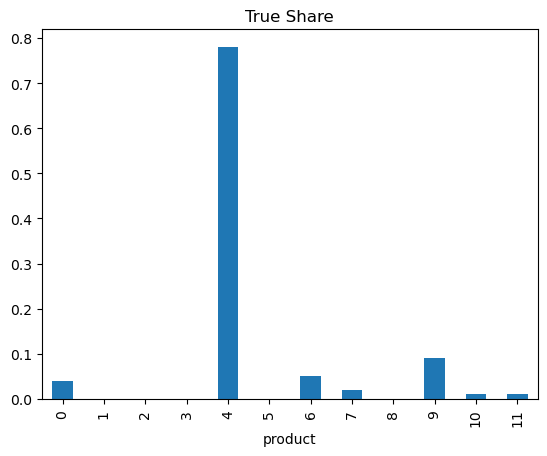

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
(simulated_data.groupby('product').apply(lambda x: np.sum(x['choice'])/100).
plot.bar(ax=ax))
ax.set_title("True Share")

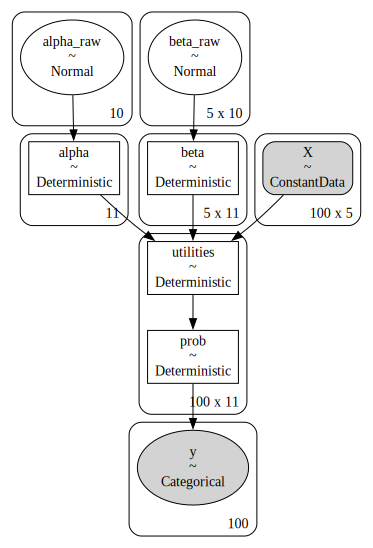

In [262]:
alternatives = 10
vars = 5
df  = (simulated_data.groupby(['customer_id', 'choice']).max(['product']).
reset_index().query('choice == 1.0').reset_index(drop=True))
X = pd.DataFrame(np.random.normal(0, 1, size=(100, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([df, X], axis=1)
y_s = pd.Categorical(df['product']).codes
predictors = ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']

def make_choice_model(alternatives, vars, observed, df, mcmc):
    with pm.Model() as model:
        alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
        beta_raw = pm.Normal('beta_raw', 0, .5, size=(vars, alternatives))

        alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))
        beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))

        X = pm.Data('X', df[predictors])
        utilities = pm.Deterministic('utilities', alpha + pm.math.dot(X, beta))

        prob = pm.Deterministic('prob', pt.special.softmax(utilities, axis=1))

        y = pm.Categorical('y', p=prob, observed=y_s)
        if mcmc: 
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(nuts_sampler='numpyro', draws=1000, random_seed=199, target_accept=0.95, idata_kwargs={"log_likelihood": True}))
            idata.extend(pm.sample_posterior_predictive(idata))
        else: 
            approx = pm.fit(100_000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
            idata = approx.sample(500)
    
    return idata, model

#idata_simple, model_simple = make_choice_model(alternatives, vars, y_s, df) 

pm.model_to_graphviz(model_simple)


In [215]:
az.summary(idata, var_names=['alpha', 'beta'])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
alpha[1],-1.856,0.586,-3.029,-0.821,0.023,0.016,676.0,767.0,1.00
alpha[2],-1.418,0.509,-2.309,-0.433,0.021,0.015,582.0,1494.0,1.00
alpha[3],-1.712,0.578,-2.815,-0.661,0.027,0.019,454.0,571.0,1.01
alpha[4],4.058,0.345,3.437,4.670,0.016,0.011,486.0,823.0,1.01
...,...,...,...,...,...,...,...,...,...
"beta[4, 6]",-0.037,0.260,-0.518,0.506,0.010,0.011,623.0,732.0,1.04
"beta[4, 7]",-0.292,0.358,-1.086,0.192,0.050,0.036,62.0,189.0,1.05
"beta[4, 8]",0.246,0.464,-0.498,1.287,0.070,0.050,50.0,170.0,1.06
"beta[4, 9]",0.120,0.287,-0.447,0.675,0.033,0.026,82.0,498.0,1.06


<Axes: xlabel='y / y'>

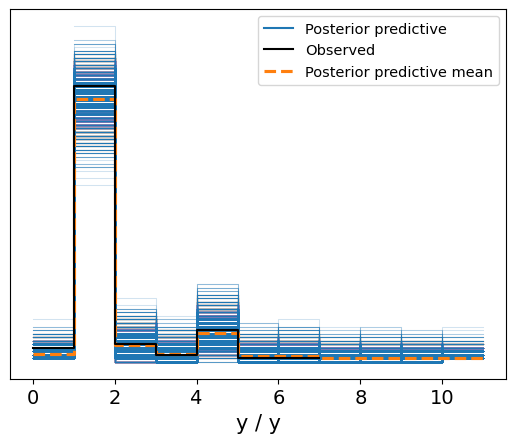

In [213]:
az.plot_ppc(idata_simple)

In [216]:
az.extract(idata.posterior.prob).mean(dim='prob_dim_0').mean(dim='sample')

<xarray.Dataset>
Dimensions:     (prob_dim_1: 11)
Coordinates:
  * prob_dim_1  (prob_dim_1) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    prob        (prob_dim_1) float64 0.02072 0.0192 0.02508 ... 0.06597 0.01769

## Adding Subject Specific Utilities



In [20]:
repeat_sales

,choice,customer_id,product
0,1.0,0,9
1,1.0,0,4
2,1.0,0,4
3,1.0,1,9
4,1.0,1,4
...,...,...,...
295,1.0,98,0
296,1.0,98,4
297,1.0,99,4
298,1.0,99,4


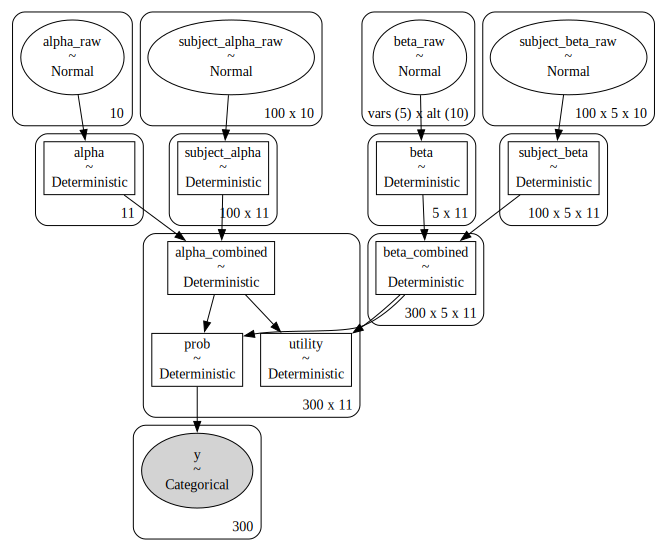

In [261]:
alternatives = 10
vars = 5
customers = 100
observations = 300
X = pd.DataFrame(np.random.normal(0, 1, size=(300, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([repeat_sales, X], axis=1)
y_s = pd.Categorical(df['product']).codes
predictors = ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']

def make_customer_model(alternatives, vars, customers, observed, df, mcmc=True):
    customer_idx, uniques = pd.factorize(df['customer_id'])
    coords = {'customer': range(customers) , 'vars': range(vars), 'alt': range(alternatives)}
    with pm.Model(coords=coords) as model:
        alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
        alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))

        subject_alpha_raw = pm.Normal('subject_alpha_raw', 0, 1, size=(customers, alternatives))
        subject_alpha = pm.Deterministic('subject_alpha', pt.concatenate([np.zeros((customers,1)), subject_alpha_raw], axis=1))
        alpha_combined = pm.Deterministic('alpha_combined', alpha + subject_alpha[customer_idx])

        beta_raw = pm.Normal('beta_raw', 0, .5, size=(vars, alternatives))
        beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))
        subject_beta_raw =  pm.Normal('subject_beta_raw', 0, 1, size=(customers, vars, alternatives))
        subject_beta = pm.Deterministic('subject_beta', pt.concatenate([np.zeros((customers, vars, 1)), subject_beta_raw], axis=2))
    
        beta_combined = pm.Deterministic('beta_combined', beta + subject_beta[customer_idx])

        utilities = []
        probs = []
        for i in df['customer_id'].unique():
            X = df[df['customer_id']==i][predictors]
            utility = alpha_combined[i, :] + pm.math.dot(X, beta_combined[i, :, :])
            utilities.append(utility)
            prob = pt.special.softmax(utility, axis=1)
            probs.append(prob)
        
        utility = pm.Deterministic('utility', pt.concatenate(utilities))
        prob = pm.Deterministic('prob', pt.concatenate(probs))
        y = pm.Categorical('y', p=prob, observed=y_s)
        if mcmc: 
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(nuts_sampler='numpyro', draws=1000, random_seed=199, target_accept=0.95, idata_kwargs={"log_likelihood": True}))
            idata.extend(pm.sample_posterior_predictive(idata))
        else: 
            approx = pm.fit(100_000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
            idata = approx.sample(500)

    return idata, model

#idata_customer, model_customer = make_customer_model(alternatives, vars, customers, y_s, df)

pm.model_to_graphviz(model_customer)


In [218]:
az.summary(idata_customer, var_names=['alpha', 'beta'])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
alpha[1],-1.915,0.577,-2.927,-0.756,0.010,0.007,3199.0,3038.0,1.0
alpha[2],-1.505,0.536,-2.530,-0.540,0.009,0.007,3255.0,2987.0,1.0
alpha[3],-1.800,0.563,-2.910,-0.814,0.011,0.008,2754.0,2673.0,1.0
alpha[4],3.954,0.348,3.345,4.618,0.008,0.006,1741.0,2162.0,1.0
...,...,...,...,...,...,...,...,...,...
"beta[4, 6]",-0.308,0.315,-0.893,0.271,0.006,0.004,3261.0,3200.0,1.0
"beta[4, 7]",0.277,0.348,-0.383,0.903,0.006,0.004,3464.0,3219.0,1.0
"beta[4, 8]",0.007,0.391,-0.706,0.761,0.006,0.006,4111.0,3253.0,1.0
"beta[4, 9]",-0.043,0.333,-0.662,0.582,0.006,0.005,2852.0,2770.0,1.0


<Axes: xlabel='y / y'>

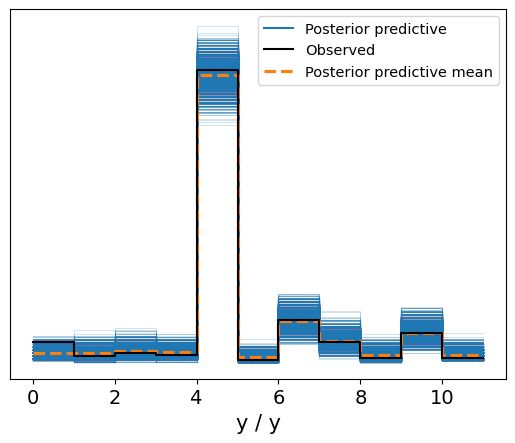

In [219]:
az.plot_ppc(idata_customer)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

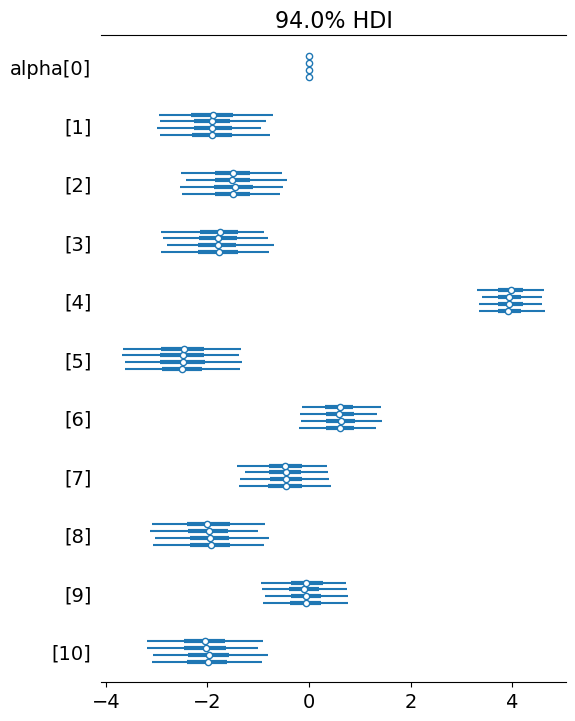

In [224]:
az.plot_forest(idata_customer, var_names=['alpha'])

In [226]:
az.extract(idata_customer.posterior.prob).mean(dim='prob_dim_0').mean(dim='sample')

<xarray.Dataset>
Dimensions:     (prob_dim_1: 11)
Coordinates:
  * prob_dim_1  (prob_dim_1) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    prob        (prob_dim_1) float64 0.02065 0.0196 0.02509 ... 0.06659 0.0168

## Add correlation matrix on Betas

Sampling: [alpha_raw, beta_raw_, chol, subject_alpha_raw, subject_beta_raw, y]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.053142
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:25:06.465734
Transforming variables...
Transformation time =  0:00:01.733662
Computing Log Likelihood...


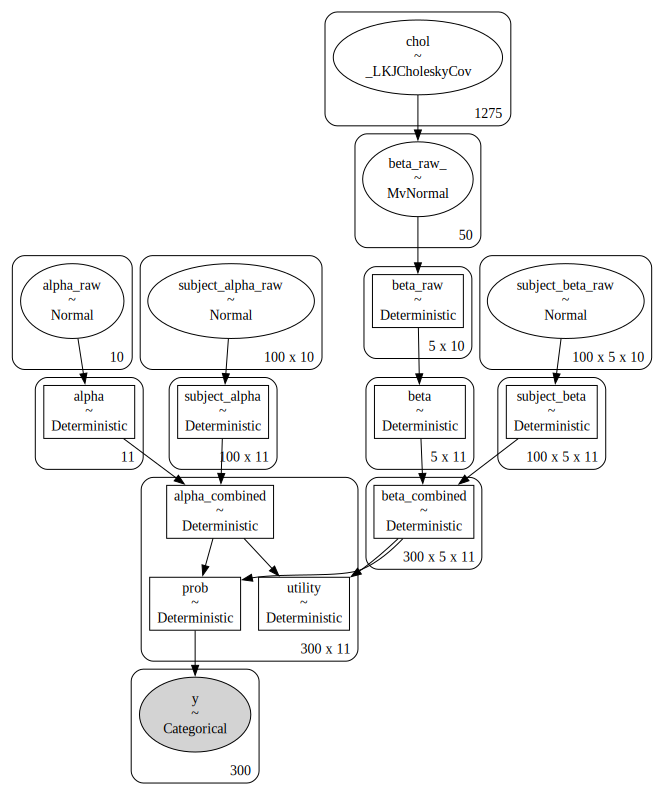

In [228]:
alternatives = 10
vars = 5
customers = 100
observations = 300
X = pd.DataFrame(np.random.normal(0, 1, size=(300, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([repeat_sales, X], axis=1)
y_s = pd.Categorical(df['product']).codes
predictors = ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']


def make_correlated_customer_model(alternatives, vars, customers, observed, df, mcmc=True):
    customer_idx, uniques = pd.factorize(df['customer_id'])
    alt_indx = list(range(alternatives))
    matrix_size = vars*alternatives 
    coords = {'customer': range(customers) , 'vars': range(vars), 'alt': range(alternatives)}
    with pm.Model(coords=coords) as model:
        alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
        alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))

        subject_alpha_raw = pm.Normal('subject_alpha_raw', 0, 1, size=(customers, alternatives))
        subject_alpha = pm.Deterministic('subject_alpha', pt.concatenate([np.zeros((customers,1)), subject_alpha_raw], axis=1))
        alpha_combined = pm.Deterministic('alpha_combined', alpha + subject_alpha[customer_idx])

        packed_chol = pm.LKJCholeskyCov(
            'chol', n=matrix_size, eta=4.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=False,
            )
        chol = pm.expand_packed_triangular(matrix_size, packed_chol, lower=True)
        beta_raw = pm.MvNormal('beta_raw_', mu=np.zeros(matrix_size), chol=chol)

        beta_raw = pm.Deterministic('beta_raw', beta_raw.reshape((vars, alternatives)))
        beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))
        
        subject_beta_raw =  pm.Normal('subject_beta_raw', 0, 1, size=(customers, vars, alternatives))
        subject_beta = pm.Deterministic('subject_beta', pt.concatenate([np.zeros((customers, vars, 1)), subject_beta_raw], axis=2))
    
        beta_combined = pm.Deterministic('beta_combined', beta + subject_beta[customer_idx])

        utilities = []
        probs = []
        for i in df['customer_id'].unique():
            X = df[df['customer_id']==i][predictors]
            utility = alpha_combined[i, :] + pm.math.dot(X, beta_combined[i, :, :])
            utilities.append(utility)
            prob = pt.special.softmax(utility, axis=1)
            probs.append(prob)
        
        utility = pm.Deterministic('utility', pt.concatenate(utilities))
        prob = pm.Deterministic('prob', pt.concatenate(probs))
        y = pm.Categorical('y', p=prob, observed=y_s)
        if mcmc: 
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(nuts_sampler='numpyro', draws=1000, random_seed=199, target_accept=0.99, idata_kwargs={"log_likelihood": True}))
            idata.extend(pm.sample_posterior_predictive(idata))
        else: 
            approx = pm.fit(100_000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
            idata = approx.sample(500)
    
    return idata, model

idata_corr, model_corr = make_correlated_customer_model(alternatives, vars, customers, y_s, df)

pm.model_to_graphviz(model_corr)

<Axes: >

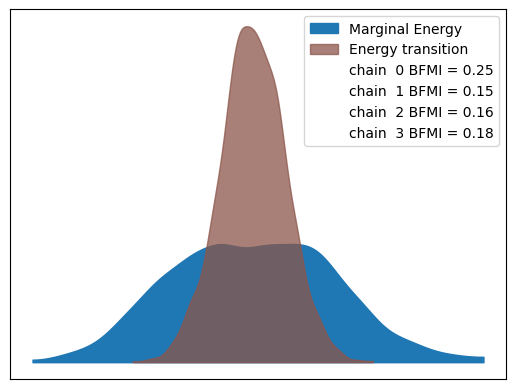

In [232]:
az.plot_energy(idata_corr)

In [230]:
az.summary(idata_corr, var_names=['alpha', 'beta'])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
alpha[1],-1.856,0.586,-3.029,-0.821,0.023,0.016,676.0,767.0,1.00
alpha[2],-1.418,0.509,-2.309,-0.433,0.021,0.015,582.0,1494.0,1.00
alpha[3],-1.712,0.578,-2.815,-0.661,0.027,0.019,454.0,571.0,1.01
alpha[4],4.058,0.345,3.437,4.670,0.016,0.011,486.0,823.0,1.01
...,...,...,...,...,...,...,...,...,...
"beta[4, 6]",-0.037,0.260,-0.518,0.506,0.010,0.011,623.0,732.0,1.04
"beta[4, 7]",-0.292,0.358,-1.086,0.192,0.050,0.036,62.0,189.0,1.05
"beta[4, 8]",0.246,0.464,-0.498,1.287,0.070,0.050,50.0,170.0,1.06
"beta[4, 9]",0.120,0.287,-0.447,0.675,0.033,0.026,82.0,498.0,1.06


<Axes: xlabel='y / y'>

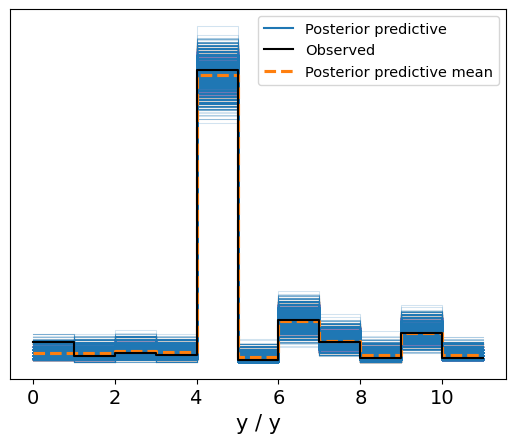

In [231]:
az.plot_ppc(idata_corr)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

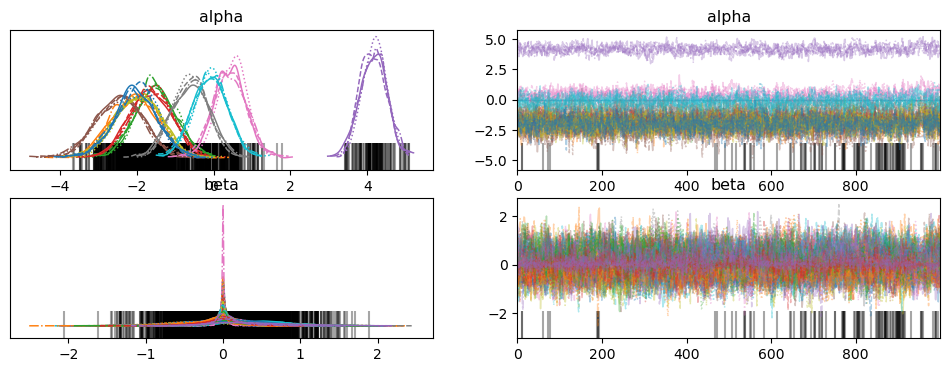

In [233]:
az.plot_trace(idata_corr, var_names=['alpha', 'beta'])

### Compare Models



In [235]:
compare = az.compare({'customer': idata_customer, 'corr': idata_corr})

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
corr,0,-445.950249,243.203272,0.000000,0.564913,26.103725,0.000000,True,log
customer,1,-457.085007,247.717630,11.134758,0.435087,25.984805,14.834059,True,log


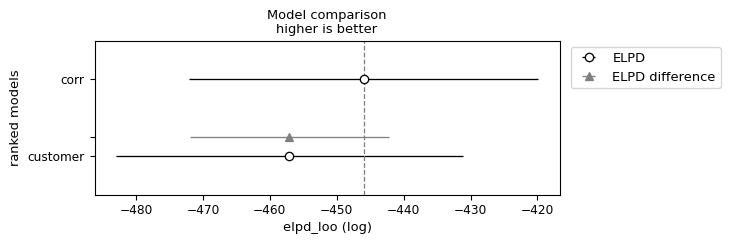

In [236]:
az.plot_compare(compare)
compare

## Real Data

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [alpha_raw, beta_raw, y]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.878829
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:15.117098
Transforming variables...
Transformation time =  0:00:00.633109
Computing Log Likelihood...


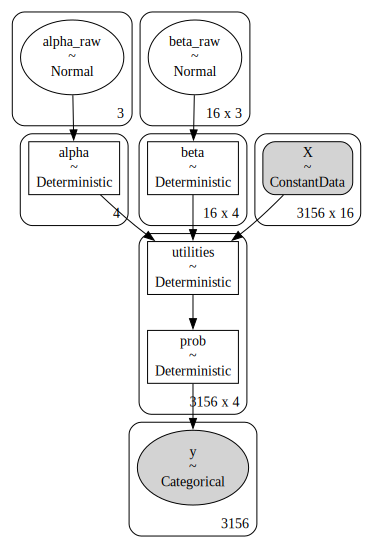

In [264]:

cracker_choice_short = pd.read_csv('../data/cracker_choice_short.csv')
df = pd.concat([cracker_choice_short, pd.get_dummies(cracker_choice_short['lastChoice'], prefix='last_choice')], axis=1)
df['customer_id'] = df['personId']
y_s = pd.Categorical(df['choice']).codes

predictors = ['disp.sunshine', 'disp.keebler',
       'disp.nabisco', 'disp.private', 'feat.sunshine', 'feat.keebler',
       'feat.nabisco', 'feat.private', 'price.sunshine', 'price.keebler',
       'price.nabisco', 'price.private', 'last_choice_keebler',
       'last_choice_nabisco', 'last_choice_private', 'last_choice_sunshine']
       
x_s = df[predictors].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_s.shape, y_s.shape, np.unique(y_s)


alternatives = 3
vars = len(predictors)
customers = len(df['customer_id'].unique())

idata_crackers, model_cracker = make_choice_model(alternatives, vars, y_s, df)

# customer_idx, uniques = pd.factorize(df['customer_id'])
# coords = {'customer': range(customers) , 'vars': range(vars), 'alt': range(alternatives)}
# with pm.Model(coords=coords) as model_cracker:
#        alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
#        alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))

#        subject_alpha_raw = pm.Normal('subject_alpha_raw', 0, 1, size=(customers, alternatives))
#        subject_alpha = pm.Deterministic('subject_alpha', pt.concatenate([np.zeros((customers,1)), subject_alpha_raw], axis=1))
#        alpha_combined = pm.Deterministic('alpha_combined', alpha + subject_alpha[customer_idx])

#        beta_raw = pm.Normal('beta_raw', 0, .5, size=(vars, alternatives))
#        beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))
#        subject_beta_raw =  pm.Normal('subject_beta_raw', 0, 1, size=(customers, vars, alternatives))
#        subject_beta = pm.Deterministic('subject_beta', pt.concatenate([np.zeros((customers, vars, 1)), subject_beta_raw], axis=2))

#        beta_combined = pm.Deterministic('beta_combined', beta + subject_beta[customer_idx])

#        utilities = []
#        probs = []
#        for i in df['customer_id'].unique():
#               X = df[df['customer_id']==i][predictors]
#               utility = alpha_combined[i, :] + pm.math.dot(X, beta_combined[i, :, :])
#               utilities.append(utility)
#               prob = pt.special.softmax(utility, axis=1)
#               probs.append(prob)

#        utility = pm.Deterministic('utility', pt.concatenate(utilities))
#        prob = pm.Deterministic('prob', pt.concatenate(probs))
#        y = pm.Categorical('y', p=prob, observed=y_s)
#        idata = pm.sample_prior_predictive()
#        idata.extend(pm.sample(1000, tune=2000, random_seed=199, target_accept=0.95, idata_kwargs={"log_likelihood": True}))
#        idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model_cracker)




<Axes: xlabel='y / y'>

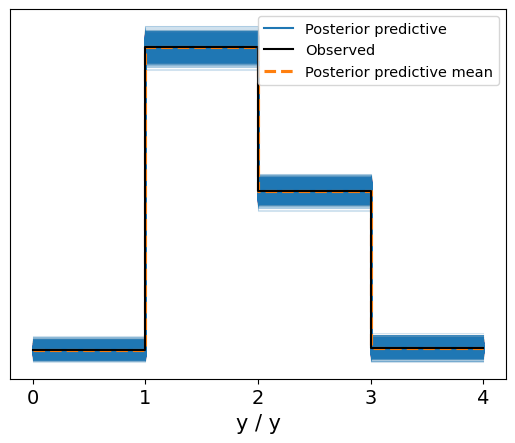

In [265]:
az.plot_ppc(idata_crackers)

Sampling: [alpha_raw, beta_raw, subject_alpha_raw, subject_beta_raw, y]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:08.221216
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:49:36.311599
Transforming variables...
Transformation time =  0:00:19.125559
Computing Log Likelihood...
Log Likelihood time =  0:00:14.941430


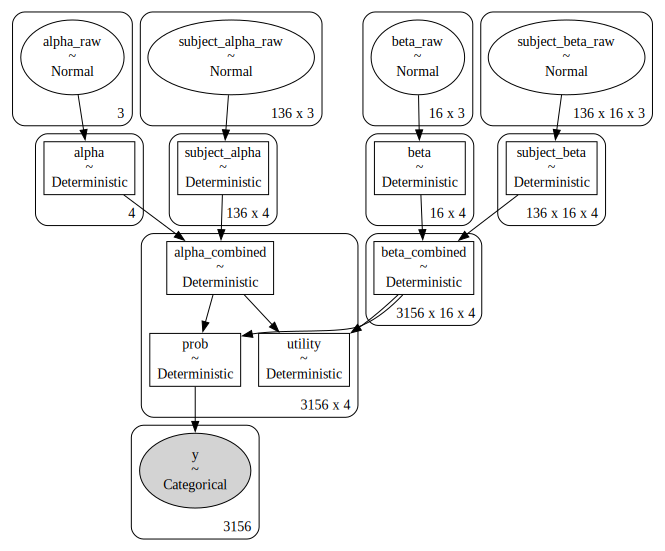

In [266]:
idata_crackers_cust, model_cracker_cust = make_customer_model(alternatives, vars, customers, y_s, df)
pm.model_to_graphviz(model_cracker_cust)

<Axes: xlabel='y / y'>

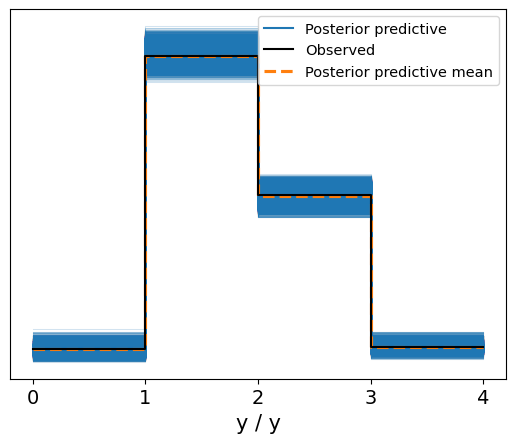

In [267]:
az.plot_ppc(idata_crackers_cust)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

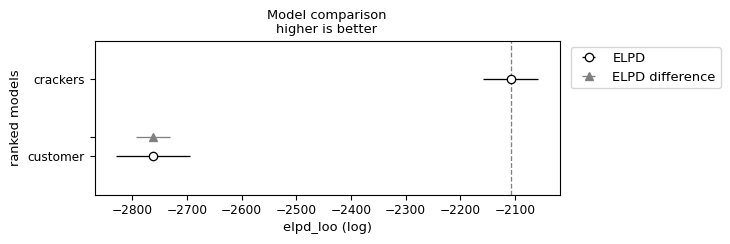

In [270]:
compare_crackers = az.compare({'crackers': idata_crackers, 'customer': idata_crackers_cust})
az.plot_compare(compare_crackers)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

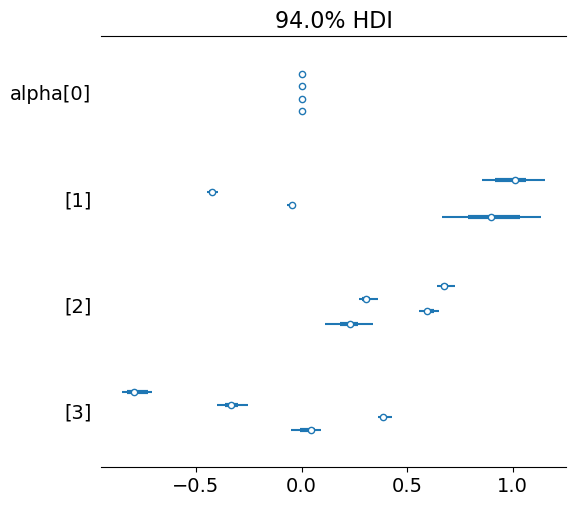

In [272]:
az.plot_forest(idata_crackers_cust, var_names=['alpha'])

In [273]:
az.summary(idata_crackers_cust, var_names='alpha')

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
alpha[1],0.358,0.615,-0.451,1.095,0.305,0.234,5.0,18.0,3.16
alpha[2],0.455,0.193,0.180,0.724,0.095,0.073,5.0,12.0,2.81
alpha[3],-0.173,0.435,-0.843,0.407,0.216,0.166,4.0,12.0,3.51
